In [ ]:
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Function

In [ ]:
def predict_stock(stock, column, period, timestep):
  stock = stock
  column = column
  period = period
  timestep = timestep
  
  select_stock(stock, period, timestep)
  prepro(df, column, timestep)
  result = pred_stock(period, timestep)
  return result

In [ ]:
# 필요한 변수 = ['High', 'Low', 'Close']
# 종목 선택 & 앞으로 예측할 기간 선택

def select_stock(stock, period, timestep):
    df = pdr.get_data_yahoo(stock, '2000-01-01')
    tempdf = df.copy()[['High', 'Low', 'Close']]
    #타겟 설정
    tempdf['Target_YMD'] = 0
    tempdf['Target_High'] = 0
    tempdf['Target_Low'] = 0
    tempdf['Target_Close'] = 0
    for i in range(len(tempdf)):
        try:
            tempdf['Target_YMD'].iloc[i] = str(tempdf.index[i+period]).split(' ')[0]
            tempdf['Target_High'].iloc[i] = tempdf['High'].iloc[i+period]
            tempdf['Target_Low'].iloc[i] = tempdf['Low'].iloc[i+period]
            tempdf['Target_Close'].iloc[i] = tempdf['Close'].iloc[i+period]
        except:
            continue

    tempdf_index = []
    for i in range(len(tempdf)):
        indexword =  str(tempdf.index[i]).split(' ')[0]
        tempdf_index.append(indexword)

    tempdf.index = tempdf_index
    global future_test
    future_test = tempdf[-period-(timestep-1):][['High', 'Low', 'Close']] # 3은 shift 횟수
    tempdf = tempdf[:-period]
    
    return tempdf

In [ ]:
# df = select_stock(stock_code, period) 
def prepro(df, column, timestep):
    x_data = df[['High', 'Low', 'Close']]
    #x_data log&MinMaxScale
    x_data = np.log(x_data)
    global sc_x
    sc_x = MinMaxScaler()
    x_data = pd.DataFrame(sc_x.fit_transform(x_data), index=x_data.index, columns=x_data.columns)
    #Time step 결정
    lst = []
    lst.append('High')
    for step in range(1,timestep):
        x_data['High_{}'.format(step)] = x_data['High'].shift(step)
        lst.append('High_'+str(step))
    lst.append('Low')
    for step in range(1,timestep):
        x_data['Low_{}'.format(step)] = x_data['Low'].shift(step)
        lst.append('Low_'+str(step))
    lst.append('Close')
    for step in range(1,timestep):
        x_data['Close_{}'.format(step)] = x_data['Close'].shift(step)
        lst.append('Close_'+str(step))
    x_data = x_data.dropna()
    x_data = x_data[lst]
    
    #y_data
    #y columns 선택변수로 만들 것 
    target_word = 'Target_'+str(column)
    y_data = df[target_word][(timestep-1):] # Timestep의 갯수만큼 
    y_ymd = df['Target_YMD'][(timestep-1):]
    y_data = np.log(y_data)
    global sc_y 
    sc_y = MinMaxScaler()
    y_data = sc_y.fit_transform(np.array(y_data).reshape(-1,1))
    #train/test set split  _ test_size = 1000
    global x_test_t
    global y_test
    y_train = y_data[:-1000]
    y_test = y_data[-1000:]
    x_train = x_data[:-1000]
    x_test = x_data[-1000:]

    #x_data reshape(len, feature, timestep)
    x_train_t = np.array(x_train).reshape(len(x_train), 3, timestep)
    x_test_t = np.array(x_test).reshape(len(x_test), 3, timestep)
    
    #Machine Learning Model
    global model
    model = tf.keras.models.Sequential()
    model.add(LSTM(10, input_shape=(x_train_t.shape[1], x_train_t.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    model.fit(x_train_t, y_train, epochs=10, batch_size =1, verbose =1)
    
    pred = model.predict(x_test_t)
    pred = np.exp(sc_y.inverse_transform(pred))
    predict = pd.DataFrame(pred)
    predict.columns = ['Predict_{}'.format(column)]
    predict['Real_{}'.format(column)] = np.exp(sc_y.inverse_transform(y_test))
    predict.index = y_ymd[-1000:]
    predict['Error_{}'.format(column)] = predict['Real_{}'.format(column)] - predict['Predict_{}'.format(column)]
    global adj
    lennum = round((len(predict))* (2/3))
    adj = predict['Error_{}'.format(column)][-int(lennum):].mean()
    print('Mean Error:', adj)
    return predict
    

In [ ]:
def pred_stock(period,timestep):
  model.fit(x_test_t, y_test, epochs=10, batch_size =1, verbose =1)
  x_data = np.log(future_test)
  x_data = pd.DataFrame(sc_x.transform(x_data), index= x_data.index, columns=x_data.columns)
  #Time step 결정
  lst = []
  lst.append('High')
  for step in range(1,timestep):
      x_data['High_{}'.format(step)] = x_data['High'].shift(step)
      lst.append('High_'+str(step))
  lst.append('Low')
  for step in range(1,timestep):
      x_data['Low_{}'.format(step)] = x_data['Low'].shift(step)
      lst.append('Low_'+str(step))
  lst.append('Close')
  for step in range(1,timestep):
      x_data['Close_{}'.format(step)] = x_data['Close'].shift(step)
      lst.append('Close_'+str(step))
  x_data = x_data.dropna()
  x_data = x_data[lst] 
  #x_data reshape(len, feature, timestep) 
  x_data_t = np.array(x_data).reshape(len(x_data), 3, timestep) 

  #Prediction
  pred = model.predict(x_data_t)
  pred = np.exp(sc_y.inverse_transform(pred))
  
  tmplst=[]
  for i in range(1,period+1):
    tmpwd = future_test.index[-1] + " +"+str(i)+"일"
    tmplst.append(tmpwd)

  predict = pd.DataFrame(pred, columns = ['Col'])
  predict['Adj_Col'] = predict['Col']+ adj
  predict['Date'] = tmplst

  return predict

In [ ]:
# df = select_stock(stock_code, period)  
def prepro2(df, column, timestep):   # x_data.shape(len(x_train), timestep, 3)
    x_data = df[['High', 'Low', 'Close']]
    #x_data log&MinMaxScale
    x_data = np.log(x_data)
    global sc_x
    sc_x = MinMaxScaler()
    x_data = pd.DataFrame(sc_x.fit_transform(x_data), index=x_data.index, columns=x_data.columns)
    #Time step 결정
    for step in range(1,timestep):
        x_data['High_{}'.format(step)] = x_data['High'].shift(step)
    for step in range(1,timestep):
        x_data['Low_{}'.format(step)] = x_data['Low'].shift(step)
    for step in range(1,timestep):
        x_data['Close_{}'.format(step)] = x_data['Close'].shift(step)
    x_data = x_data.dropna()
        
    #y_data
    #y columns 선택변수로 만들 것 
    target_word = 'Target_'+str(column)
    y_data = df[target_word][(timestep-1):] # Timestep의 갯수만큼 
    y_ymd = df['Target_YMD'][(timestep-1):]
    y_data = np.log(y_data)
    global sc_y 
    sc_y = MinMaxScaler()
    y_data = sc_y.fit_transform(np.array(y_data).reshape(-1,1))
    #train/test set split  _ test_size = 1000
    global x_test_t
    global y_test
    y_train = y_data[:-1000]
    y_test = y_data[-1000:]
    x_train = x_data[:-1000]
    x_test = x_data[-1000:]

    #x_data reshape(len, feature, timestep)
    x_train_t = np.array(x_train).reshape(len(x_train), timestep, 3)
    x_test_t = np.array(x_test).reshape(len(x_test), timestep, 3)
    
    #Machine Learning Model
    global model
    model = tf.keras.models.Sequential()
    model.add(LSTM(10, input_shape=(x_train_t.shape[1], x_train_t.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    model.fit(x_train_t, y_train, epochs=50, batch_size =1, verbose =1)
    
    pred = model.predict(x_test_t)
    pred = np.exp(sc_y.inverse_transform(pred))
    predict = pd.DataFrame(pred)
    predict.columns = ['Predict_{}'.format(column)]
    predict['Real_{}'.format(column)] = np.exp(sc_y.inverse_transform(y_test))
    predict.index = y_ymd[-1000:]
    predict['Error_{}'.format(column)] = predict['Real_{}'.format(column)] - predict['Predict_{}'.format(column)]
    global adj
    lennum = round((len(predict))* (2/3))
    adj = predict['Error_{}'.format(column)][-int(lennum):].mean()
    print('Mean Error:', adj)
    return predict
    


In [ ]:
def pred_stock2(period,timestep):
  model.fit(x_test_t, y_test, epochs=50, batch_size =1, verbose =1) 
  x_data = np.log(future_test)
  x_data = pd.DataFrame(sc_x.transform(x_data), index= x_data.index, columns=x_data.columns)
  #Time step 결정
  for step in range(1,timestep):
      x_data['High_{}'.format(step)] = x_data['High'].shift(step)
  for step in range(1,timestep):
      x_data['Low_{}'.format(step)] = x_data['Low'].shift(step)
  for step in range(1,timestep):
      x_data['Close_{}'.format(step)] = x_data['Close'].shift(step)
  x_data = x_data.dropna()
  #x_data reshape(len, feature, timestep) 
  x_data_t = np.array(x_data).reshape(len(x_data), timestep, 3) 

  #Prediction
  pred = model.predict(x_data_t)
  pred = np.exp(sc_y.inverse_transform(pred))
  
  tmplst=[]
  for i in range(1,period+1):
    tmpwd = future_test.index[-1] + " +"+str(i)+"일"
    tmplst.append(tmpwd)

  predict = pd.DataFrame(pred, columns = ['Col'])
  predict['Adj_Col'] = predict['Col']+ adj
  predict['Date'] = tmplst

  return predict

In [ ]:
# 테스트 셋 주기적으로 업데이트하는 함수
# 트레이닝 미리 해놓을 것

def setup(timestep, column):
    global x_data
    global y_data
    x_data = df[['High', 'Low', 'Close']]
    #x_data log&MinMaxScale
    x_data = np.log(x_data)
    global sc_x
    sc_x = MinMaxScaler()
    x_data = pd.DataFrame(sc_x.fit_transform(x_data), index=x_data.index, columns=x_data.columns)
    #Time step 결정
    lst = []
    lst.append('High')
    for step in range(1,timestep):
        x_data['High_{}'.format(step)] = x_data['High'].shift(step)
        lst.append('High_'+str(step))
    lst.append('Low')
    for step in range(1,timestep):
        x_data['Low_{}'.format(step)] = x_data['Low'].shift(step)
        lst.append('Low_'+str(step))
    lst.append('Close')
    for step in range(1,timestep):
        x_data['Close_{}'.format(step)] = x_data['Close'].shift(step)
        lst.append('Close_'+str(step))
    x_data = x_data.dropna()
    x_data = x_data[lst]
    
    #y_data
    #y columns 선택변수로 만들 것 
    target_word = 'Target_'+str(column)
    y_data = df[target_word][(timestep-1):] # Timestep의 갯수만큼 
    y_ymd = df['Target_YMD'][(timestep-1):]
    y_data = np.log(y_data)
    global sc_y 
    sc_y = MinMaxScaler()
    y_data = sc_y.fit_transform(np.array(y_data).reshape(-1,1))
    #train/test set split  _ test_size = 1000

    y_train = y_data[:-1000]
    x_train = x_data[:-1000]

    #x_data reshape(len, feature, timestep)
    x_train_t = np.array(x_train).reshape(len(x_train), 3, timestep)
    
    #Machine Learning Model
    global model
    model = tf.keras.models.Sequential()
    model.add(LSTM(10, input_shape=(x_train_t.shape[1], x_train_t.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    model.fit(x_train_t, y_train, epochs=10, batch_size =1, verbose =1)



def update(repeat):
  repeat = repeat
  first = 1000 -repeat
  second = first - repeat
  y_ymd = df['Target_YMD'][(timestep-1):]
  y_test = y_data[-1000:-first]
  x_test = x_data[-1000:-first]
  x_test_t = np.array(x_test).reshape(len(x_test), 3, timestep)
  pred = model.predict(x_test_t)
  pred = np.exp(sc_y.inverse_transform(pred))
  pred = pd.DataFrame(pred, index= y_ymd[-1000:-first], columns=['Prediction'])
  totalpred = pd.DataFrame()
  totalpred = pd.concat([totalpred, pred])

  repeatnum = int(1000 / repeat)
  for i in range(repeatnum):  #
    model.fit(x_test_t, y_test, epochs=10, batch_size =1, verbose =1)  
    if second > 0:
      x_test = x_data[-first:-second]
      y_test = y_data[-first:-second]
      x_test_t = np.array(x_test).reshape(len(x_test), 3, timestep)
      pred = model.predict(x_test_t)
      pred = np.exp(sc_y.inverse_transform(pred))
      pred = pd.DataFrame(pred, index= y_ymd[-first:-second], columns=['Prediction'])
      totalpred = pd.concat([totalpred, pred])
    elif second == 0:
      x_test = x_data[-first:]
      y_test = y_data[-first:]
      x_test_t = np.array(x_test).reshape(len(x_test), 3, timestep)
      pred = model.predict(x_test_t)
      pred = np.exp(sc_y.inverse_transform(pred))
      pred = pd.DataFrame(pred, index= y_ymd[-first:], columns=['Prediction'])
      totalpred = pd.concat([totalpred, pred])
    first = first-(repeat)
    second = second-(repeat)



  totalpred['Real']= np.exp(sc_y.inverse_transform(y_data[-1000:]))
  totalpred['Error'] = totalpred[totalpred.columns[1]] - totalpred[totalpred.columns[0]]
  return totalpred

In [ ]:
def pred_stock2(period,timestep):
  x_data = np.log(future_test)
  x_data = pd.DataFrame(sc_x.transform(x_data), index= x_data.index, columns=x_data.columns)
  #Time step 결정
  lst = []
  lst.append('High')
  for step in range(1,timestep):
      x_data['High_{}'.format(step)] = x_data['High'].shift(step)
      lst.append('High_'+str(step))
  lst.append('Low')
  for step in range(1,timestep):
      x_data['Low_{}'.format(step)] = x_data['Low'].shift(step)
      lst.append('Low_'+str(step))
  lst.append('Close')
  for step in range(1,timestep):
      x_data['Close_{}'.format(step)] = x_data['Close'].shift(step)
      lst.append('Close_'+str(step))
  x_data = x_data.dropna()
  x_data = x_data[lst] 
  #x_data reshape(len, feature, timestep) 
  x_data_t = np.array(x_data).reshape(len(x_data), 3, timestep) 

  #Prediction
  pred = model.predict(x_data_t)
  pred = np.exp(sc_y.inverse_transform(pred))
  
  tmplst=[]
  for i in range(1,period+1):
    tmpwd = future_test.index[-1] + " +"+str(i)+"일"
    tmplst.append(tmpwd)

  predict = pd.DataFrame(pred, columns = ['Col'])
  predict['Date'] = tmplst

  return predict

# Test

##Function List 

select_stock(stock, period, timestep)

prepro(df, column, timestep)

pred_stock(period,timestep)

## AAPL

In [ ]:
period = 10 
timestep = 2
df = select_stock('AAPL', period, timestep)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df

,High,Low,Close,Target_YMD,Target_High,Target_Low,Target_Close
2000-01-03,1.004464,0.907924,0.999442,2000-01-18,0.946429,0.896763,0.928013
2000-01-04,0.987723,0.903460,0.915179,2000-01-19,0.970982,0.922991,0.951451
2000-01-05,0.987165,0.919643,0.928571,2000-01-20,1.084821,1.013393,1.013393
2000-01-06,0.955357,0.848214,0.848214,2000-01-21,1.020089,0.983817,0.993862
2000-01-07,0.901786,0.852679,0.888393,2000-01-24,1.006696,0.938616,0.948661
...,...,...,...,...,...,...,...
2020-11-10,117.589996,114.129997,115.970001,2020-11-24,115.849998,112.589996,115.169998
2020-11-11,119.629997,116.440002,119.489998,2020-11-25,116.750000,115.169998,116.029999
2020-11-12,120.529999,118.570000,119.209999,2020-11-27,117.489998,116.220001,116.589996
2020-11-13,119.669998,117.870003,119.260002,2020-11-30,120.970001,116.809998,119.050003


In [ ]:
check = prepro2(df, 'Close', timestep)
check

Epoch 1/50
4252/4252 [==============================] - 5s 1ms/step - loss: 0.0013
Epoch 2/50
4252/4252 [==============================] - 6s 1ms/step - loss: 2.4808e-04
Epoch 3/50
4252/4252 [==============================] - 5s 1ms/step - loss: 2.4623e-04
Epoch 4/50
4252/4252 [==============================] - 6s 1ms/step - loss: 2.4619e-04
Epoch 5/50
4252/4252 [==============================] - 5s 1ms/step - loss: 2.4326e-04
Epoch 6/50
4252/4252 [==============================] - 5s 1ms/step - loss: 2.4135e-04
Epoch 7/50
4252/4252 [==============================] - 6s 1ms/step - loss: 2.4283e-04
Epoch 8/50
4252/4252 [==============================] - 6s 1ms/step - loss: 2.4136e-04
Epoch 9/50
4252/4252 [==============================] - 6s 1ms/step - loss: 2.4463e-04
Epoch 10/50
4252/4252 [==============================] - 5s 1ms/step - loss: 2.4426e-04
Epoch 11/50
4252/4252 [==============================] - 6s 1ms/step - loss: 2.4009e-04
Epoch 12/50
4252/4252 [======================

,Predict_Close,Real_Close,Error_Close
Target_YMD,,,
2016-12-12,26.379490,28.325001,1.945511
2016-12-13,26.367498,28.797501,2.430002
2016-12-14,26.242331,28.797501,2.555170
2016-12-15,26.135492,28.955000,2.819508
2016-12-16,25.957323,28.992500,3.035177
...,...,...,...
2020-11-24,86.750862,115.169998,28.419136
2020-11-25,86.391640,116.029999,29.638359
2020-11-27,87.623283,116.589996,28.966713


In [ ]:
result = pred_stock2(period, timestep)
result

Epoch 1/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.3947e-04
Epoch 2/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1997e-04
Epoch 3/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1403e-04
Epoch 4/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1376e-04
Epoch 5/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1314e-04
Epoch 6/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1423e-04
Epoch 7/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1465e-04
Epoch 8/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1166e-04
Epoch 9/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1180e-04
Epoch 10/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1489e-04
Epoch 11/50
1000/1000 [==============================] - 1s 1ms/step - loss: 1.1398e-04
Epoch 12/50
1000/1000 [==================

,Col,Adj_Col,Date
0,126.567406,138.622818,2020-12-01 +1일
1,126.255104,138.310516,2020-12-01 +2일
2,125.372261,137.427673,2020-12-01 +3일
3,124.934586,136.990005,2020-12-01 +4일
4,123.842461,135.897873,2020-12-01 +5일
5,121.598366,133.653778,2020-12-01 +6일
6,121.741028,133.796448,2020-12-01 +7일
7,123.148941,135.204361,2020-12-01 +8일
8,124.205513,136.260925,2020-12-01 +9일
9,126.408836,138.464249,2020-12-01 +10일


In [ ]:
result.to_excel('aapl_pred.xlsx', index =False)

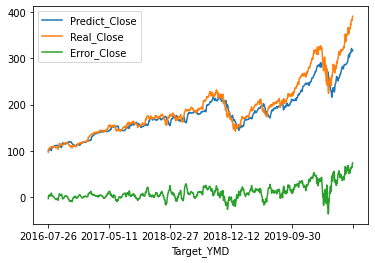

In [ ]:
check.plot()

## 삼성전자(005930.KS)

In [ ]:
period = 10
timestep = 5
df = select_stock('005930.KS', period, timestep)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
check = prepro(df, 'Close', timestep)
check

Epoch 1/10
4141/4141 [==============================] - 7s 2ms/step - loss: 0.0022
Epoch 2/10
4141/4141 [==============================] - 7s 2ms/step - loss: 5.9716e-04
Epoch 3/10
4141/4141 [==============================] - 7s 2ms/step - loss: 5.9004e-04
Epoch 4/10
4141/4141 [==============================] - 7s 2ms/step - loss: 5.8178e-04
Epoch 5/10
4141/4141 [==============================] - 7s 2ms/step - loss: 5.6538e-04
Epoch 6/10
4141/4141 [==============================] - 7s 2ms/step - loss: 5.8092e-04
Epoch 7/10
4141/4141 [==============================] - 8s 2ms/step - loss: 5.5544e-04
Epoch 8/10
4141/4141 [==============================] - 8s 2ms/step - loss: 5.5421e-04
Epoch 9/10
4141/4141 [==============================] - 7s 2ms/step - loss: 5.5031e-04
Epoch 10/10
4141/4141 [==============================] - 7s 2ms/step - loss: 5.4925e-04
Mean Error: 3946.786350965143


,Predict_Close,Real_Close,Error_Close
Target_YMD,,,
2016-06-10,26192.621094,28120.0,1927.378906
2016-06-13,26127.257812,27420.0,1292.742187
2016-06-14,26074.412109,27600.0,1525.587891
2016-06-15,26138.671875,28260.0,2121.328125
2016-06-16,26438.666016,28180.0,1741.333984
...,...,...,...
2020-07-09,47303.449219,52800.0,5496.550781
2020-07-10,47383.273438,52700.0,5316.726563
2020-07-13,47506.074219,53400.0,5893.925781


In [ ]:
result = pred_stock(period, timestep)
result

Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.3458e-04
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.2647e-04
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.1761e-04
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.2343e-04
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.5005e-04
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.2447e-04
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.3307e-04
Epoch 8/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.1031e-04
Epoch 9/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.3700e-04
Epoch 10/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.3359e-04


,Col,Adj_Col,Date
0,49671.929688,53618.714844,2020-07-15 +1일
1,49892.359375,53839.144531,2020-07-15 +2일
2,50470.460938,54417.246094,2020-07-15 +3일
3,50541.941406,54488.726562,2020-07-15 +4일
4,50226.781250,54173.566406,2020-07-15 +5일
5,50167.179688,54113.964844,2020-07-15 +6일
6,49999.722656,53946.507812,2020-07-15 +7일
7,50004.917969,53951.703125,2020-07-15 +8일
8,50174.214844,54121.000000,2020-07-15 +9일
9,50537.554688,54484.339844,2020-07-15 +10일


In [ ]:
result.to_excel('samsung_pred.xlsx', index =False)

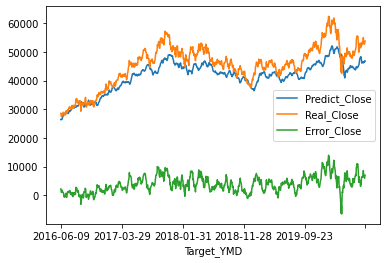

In [ ]:
check.plot()

## MSFT

In [ ]:
period = 20
timestep = 10
column = 'Close'
df = select_stock('MSFT', period, timestep)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
setup(timestep,column)

Epoch 1/10
4135/4135 [==============================] - 7s 2ms/step - loss: 0.0013
Epoch 2/10
4135/4135 [==============================] - 7s 2ms/step - loss: 0.0011
Epoch 3/10
4135/4135 [==============================] - 7s 2ms/step - loss: 0.0011
Epoch 4/10
4135/4135 [==============================] - 8s 2ms/step - loss: 0.0011
Epoch 5/10
4135/4135 [==============================] - 7s 2ms/step - loss: 0.0010
Epoch 6/10
4135/4135 [==============================] - 7s 2ms/step - loss: 0.0010
Epoch 7/10
4135/4135 [==============================] - 7s 2ms/step - loss: 0.0010
Epoch 8/10
4135/4135 [==============================] - 8s 2ms/step - loss: 0.0010
Epoch 9/10
4135/4135 [==============================] - 8s 2ms/step - loss: 0.0010
Epoch 10/10
4135/4135 [==============================] - 8s 2ms/step - loss: 0.0010


In [ ]:
result = update(50)
result

Epoch 1/10
50/50 [==============================] - 0s 2ms/step - loss: 9.1269e-05
Epoch 2/10
50/50 [==============================] - 0s 2ms/step - loss: 4.3101e-05
Epoch 3/10
50/50 [==============================] - 0s 2ms/step - loss: 4.4630e-05
Epoch 4/10
50/50 [==============================] - 0s 2ms/step - loss: 8.0182e-05
Epoch 5/10
50/50 [==============================] - 0s 2ms/step - loss: 6.9294e-05
Epoch 6/10
50/50 [==============================] - 0s 2ms/step - loss: 4.9360e-05
Epoch 7/10
50/50 [==============================] - 0s 2ms/step - loss: 5.2536e-05
Epoch 8/10
50/50 [==============================] - 0s 2ms/step - loss: 6.0518e-05
Epoch 9/10
50/50 [==============================] - 0s 2ms/step - loss: 4.5363e-05
Epoch 10/10
50/50 [==============================] - 0s 2ms/step - loss: 6.3527e-05
Epoch 1/10
50/50 [==============================] - 0s 2ms/step - loss: 1.0699e-04
Epoch 2/10
50/50 [==============================] - 0s 2ms/step - loss: 1.0993e-04
Epo

,Prediction,Real,Error
Target_YMD,,,
2016-07-22,53.724804,56.570000,2.845196
2016-07-25,53.906975,56.730000,2.823025
2016-07-26,53.702251,56.759998,3.057747
2016-07-27,54.657906,56.189999,1.532093
2016-07-28,55.326778,56.209999,0.883221
...,...,...,...
2020-07-07,180.082779,208.250000,28.167221
2020-07-08,180.804672,212.830002,32.025330
2020-07-09,181.473724,214.320007,32.846283


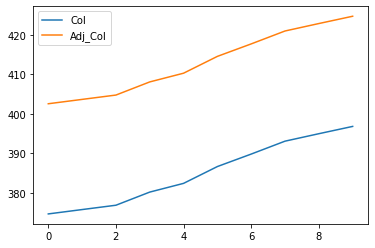

In [ ]:
result.plot()

In [ ]:
pred_stock2(period, timestep)

,Col,Date
0,198.527267,2020-07-13 +1일
1,199.337738,2020-07-13 +2일
2,200.128510,2020-07-13 +3일
3,200.558502,2020-07-13 +4일
4,200.105331,2020-07-13 +5일


In [ ]:
result[800:850]

,Prediction,Real,Error
Target_YMD,,,
2019-09-26,136.434479,139.539993,3.105515
2019-09-27,136.747620,137.729996,0.982376
2019-09-30,136.774750,139.029999,2.255249
2019-10-01,136.585297,137.070007,0.484711
2019-10-02,136.468628,134.649994,-1.818634
2019-10-03,136.657471,136.279999,-0.377472
2019-10-04,136.579758,138.119995,1.540237
2019-10-07,136.566803,137.119995,0.553192
2019-10-08,136.415405,135.669998,-0.745407


# prac

In [ ]:
check

,Predict_Close,Real_Close,Error_Close
Target_YMD,,,
2016-07-22,92.75,1.61,5.91
2016-07-25,92.98,97.34,4.36
2016-07-26,93.37,96.67,3.30
2016-07-27,93.55,102.95,9.40
2016-07-28,94.11,104.34,10.23
...,...,...,...
2020-07-07,279.24,372.69,93.45
2020-07-08,282.12,381.37,99.25
2020-07-09,282.59,383.01,100.42


In [ ]:
temp = pd.DataFrame()
lennum = int(len(check))-1
temp['Di_Predict'] = [x for x in range(lennum)]
temp['Di_Real'] = [x for x in range(lennum)]
lennum = int(len(check))-1
for i in range(lennum):
  temp['Di_Predict'][i] = check['Predict_Close'][i+1] - check['Predict_Close'][i]
  temp['Di_Real'][i] = check['Real_Close'][i+1] - check['Real_Close'][i]

temp

,Di_Predict,Di_Real
0,102,-479
1,11,-700
2,-83,180
3,60,659
4,341,-79
...,...,...
994,213,-399
995,-33,-200
996,265,-99
997,-172,699


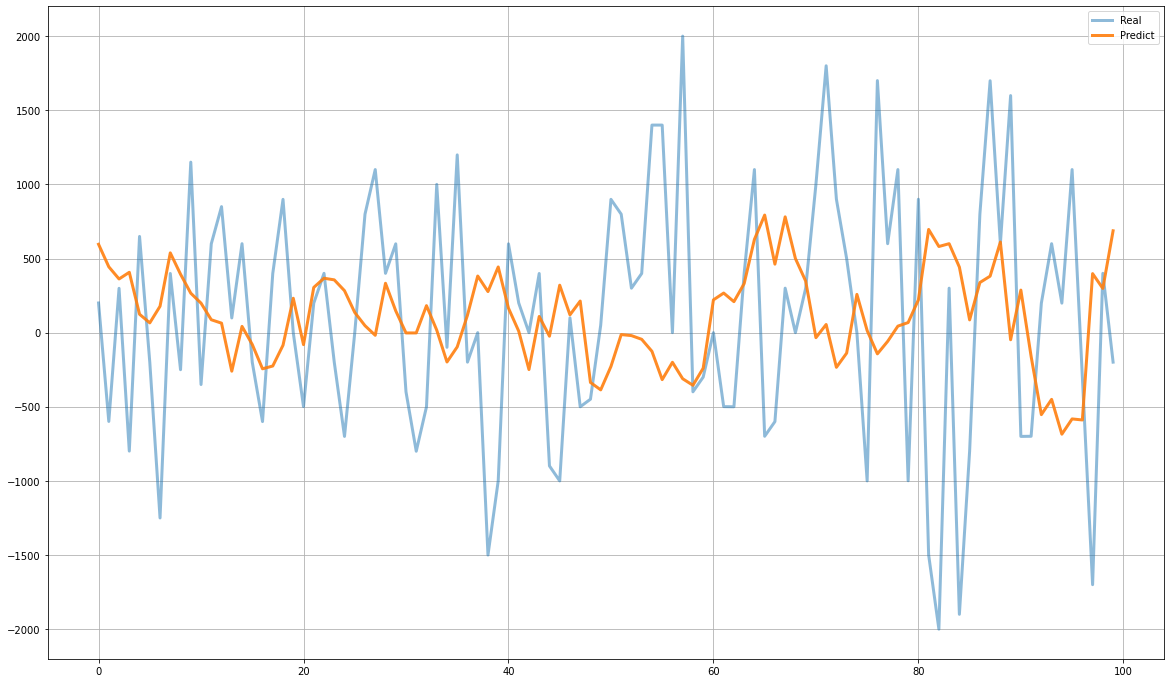

In [ ]:
from matplotlib import pyplot as plt
i = 8
plt.figure(figsize=(20,12))
plt.grid()
plt.plot(range(100), temp['Di_Real'][0+(i*100):100+(i*100)], label = 'Real', alpha = 0.5 ,linewidth=3.0)
plt.plot(range(100), temp['Di_Predict'][0+(i*100):100+(i*100)], label = 'Predict', alpha = 0.9, linewidth=3.0)
plt.legend(loc='best')
plt.show()

In [ ]:
len(temp['Di_Real'][0:100])

100

In [ ]:
temp['Di_Real'] = np.array(temp['Di_Real']).rand(5)

AttributeError: ignored

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

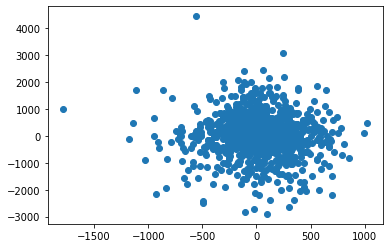

In [ ]:
plt.scatter(temp['Di_Predict'], temp['Di_Real'])

#PRACTICE FUNCTION_ 등락률

In [ ]:
df

,High,Low,Close,Target_YMD,Target_High,Target_Low,Target_Close
2000-01-04,6110.00,5660.00,6110.00,2000-01-18,6160.00,5980.00,6100.00
2000-01-05,6060.00,5520.00,5580.00,2000-01-19,6040.00,5960.00,5960.00
2000-01-06,5780.00,5580.00,5620.00,2000-01-20,6040.00,5820.00,6040.00
2000-01-07,5670.00,5360.00,5540.00,2000-01-21,5980.00,5880.00,5880.00
2000-01-10,5770.00,5580.00,5770.00,2000-01-24,5900.00,5700.00,5700.00
...,...,...,...,...,...,...,...
2020-06-24,53900.00,51600.00,52900.00,2020-07-08,53900.00,52900.00,53000.00
2020-06-25,53000.00,51900.00,51900.00,2020-07-09,53600.00,52800.00,52800.00
2020-06-26,53900.00,52200.00,53300.00,2020-07-10,53200.00,52300.00,52700.00
2020-06-29,53200.00,52000.00,52400.00,2020-07-13,53800.00,53100.00,53400.00


In [ ]:
df = pdr.get_data_yahoo('BA', '2000-01-01')

In [ ]:
df['Di'] = 0
lennum = int(len(df))
for i in range(lennum -1):
  df['Di'].iloc[i+1]= df['Close'][i+1] - df['Close'][i]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
df = pd.DataFrame(df)
df

,High,Low,Open,Close,Volume,Adj Close,Di
Date,,,,,,,
2000-01-03,41.69,39.81,41.44,40.19,2638200.00,25.74,0.00
2000-01-04,41.12,39.75,40.19,40.12,3592100.00,25.70,-0.06
2000-01-05,43.31,41.38,41.38,42.62,7631700.00,27.30,2.50
2000-01-06,43.44,41.12,42.62,43.06,4922200.00,27.58,0.44
2000-01-07,44.88,43.69,43.69,44.31,6008300.00,28.38,1.25
...,...,...,...,...,...,...,...
2020-07-07,185.07,178.65,185.07,178.88,37105300.00,178.88,-9.03
2020-07-08,181.58,175.51,179.05,180.08,38116200.00,180.08,1.20
2020-07-09,180.75,172.81,179.67,173.28,33514500.00,173.28,-6.80


In [ ]:
df['Target_Di'] = 0
df['Target_Date'] = 0
num = int(len(df))
for i in range(num-10):
  df['Target_Di'].iloc[i] = df['Di'].iloc[i+10]
  df['Target_Date'].iloc[i] = str(df.index[i+10]).split(' ')[0]
df

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,High,Low,Open,Close,Volume,Adj Close,Di,Target_Di,Target_Date
Date,,,,,,,,,
2000-01-03,41.69,39.81,41.44,40.19,2638200.00,25.74,0.00,1.00,2000-01-18
2000-01-04,41.12,39.75,40.19,40.12,3592100.00,25.70,-0.06,2.62,2000-01-19
2000-01-05,43.31,41.38,41.38,42.62,7631700.00,27.30,2.50,-1.12,2000-01-20
2000-01-06,43.44,41.12,42.62,43.06,4922200.00,27.58,0.44,-0.81,2000-01-21
2000-01-07,44.88,43.69,43.69,44.31,6008300.00,28.38,1.25,-1.38,2000-01-24
...,...,...,...,...,...,...,...,...,...
2020-07-07,185.07,178.65,185.07,178.88,37105300.00,178.88,-9.03,0.00,0
2020-07-08,181.58,175.51,179.05,180.08,38116200.00,180.08,1.20,0.00,0
2020-07-09,180.75,172.81,179.67,173.28,33514500.00,173.28,-6.80,0.00,0


In [ ]:
sc_xx = MinMaxScaler()
df['Di'] = sc_xx.fit_transform(np.array(df['Di']).reshape(-1,1))
df

,High,Low,Open,Close,Volume,Adj Close,Di,Target_Di,Target_Date
Date,,,,,,,,,
2000-01-03,41.69,39.81,41.44,40.19,2638200.00,25.74,0.57,1.00,2000-01-18
2000-01-04,41.12,39.75,40.19,40.12,3592100.00,25.70,0.57,2.62,2000-01-19
2000-01-05,43.31,41.38,41.38,42.62,7631700.00,27.30,0.61,-1.12,2000-01-20
2000-01-06,43.44,41.12,42.62,43.06,4922200.00,27.58,0.58,-0.81,2000-01-21
2000-01-07,44.88,43.69,43.69,44.31,6008300.00,28.38,0.59,-1.38,2000-01-24
...,...,...,...,...,...,...,...,...,...
2020-07-07,185.07,178.65,185.07,178.88,37105300.00,178.88,0.45,0.00,0
2020-07-08,181.58,175.51,179.05,180.08,38116200.00,180.08,0.59,0.00,0
2020-07-09,180.75,172.81,179.67,173.28,33514500.00,173.28,0.48,0.00,0


In [ ]:
#Time step 결정
lst = []
lst.append('Di')
for step in range(1,6):
    df['Di_{}'.format(step)] = df['Di'].shift(step)
    lst.append('Di_'+str(step))

df= df.dropna()
x_data = df[lst][:-10]

x_data

,Di,Di_1,Di_2,Di_3,Di_4,Di_5
Date,,,,,,
2000-01-10,0.57,0.59,0.58,0.61,0.57,0.57
2000-01-11,0.56,0.57,0.59,0.58,0.61,0.57
2000-01-12,0.58,0.56,0.57,0.59,0.58,0.61
2000-01-13,0.57,0.58,0.56,0.57,0.59,0.58
2000-01-14,0.60,0.57,0.58,0.56,0.57,0.59
...,...,...,...,...,...,...
2020-06-22,0.60,0.50,0.57,0.50,0.67,0.59
2020-06-23,0.57,0.60,0.50,0.57,0.50,0.67
2020-06-24,0.42,0.57,0.60,0.50,0.57,0.50


In [ ]:
y_data = df[:-10]['Target_Di']
sc_yy = MinMaxScaler()
y_data = sc_yy.fit_transform(np.array(y_data).reshape(-1,1))
y_data

array([[0.59338174],
       [0.58139216],
       [0.55912578],
       ...,
       [0.48136469],
       [0.64524533],
       [0.53631119]])

In [ ]:
xx_train = x_data[:-1000]
xx_test = x_data[-1000:]
yy_train = y_data[:-1000]
yy_test = y_data[-1000:]

xx_train_t = np.array(xx_train).reshape(len(xx_train), 1, 6)
xx_test_t = np.array(xx_test).reshape(len(xx_test), 1, 6)

In [ ]:
model_di = tf.keras.models.Sequential()
model_di.add(LSTM(10, input_shape=(xx_train_t.shape[1], xx_train_t.shape[2])))
model_di.add(Dense(1))
model_di.compile(loss='mean_squared_error', optimizer = 'adam')
model_di.fit(xx_train_t, yy_train, epochs=10, batch_size =1, verbose =1)

Epoch 1/10
4149/4149 [==============================] - 6s 1ms/step - loss: 0.0032
Epoch 2/10
4149/4149 [==============================] - 6s 1ms/step - loss: 4.0735e-04
Epoch 3/10
4149/4149 [==============================] - 6s 1ms/step - loss: 3.9135e-04
Epoch 4/10
4149/4149 [==============================] - 6s 1ms/step - loss: 3.8053e-04
Epoch 5/10
4149/4149 [==============================] - 6s 1ms/step - loss: 3.7221e-04
Epoch 6/10
4149/4149 [==============================] - 6s 1ms/step - loss: 3.6414e-04
Epoch 7/10
4149/4149 [==============================] - 6s 1ms/step - loss: 3.5860e-04
Epoch 8/10
4149/4149 [==============================] - 6s 1ms/step - loss: 3.5397e-04
Epoch 9/10
4149/4149 [==============================] - 6s 1ms/step - loss: 3.5506e-04
Epoch 10/10
4149/4149 [==============================] - 6s 1ms/step - loss: 3.5042e-04


In [ ]:
pred = model_di.predict(xx_test_t)
pred = np.exp(sc_yy.inverse_transform(pred))
real = sc_yy.inverse_transform(yy_test)
rs = pd.DataFrame(pred, columns=['Predcit'])
rs['Real']= real
rs['Error'] = 0 
rs['Error'] = rs['Predcit'] - rs['Real']

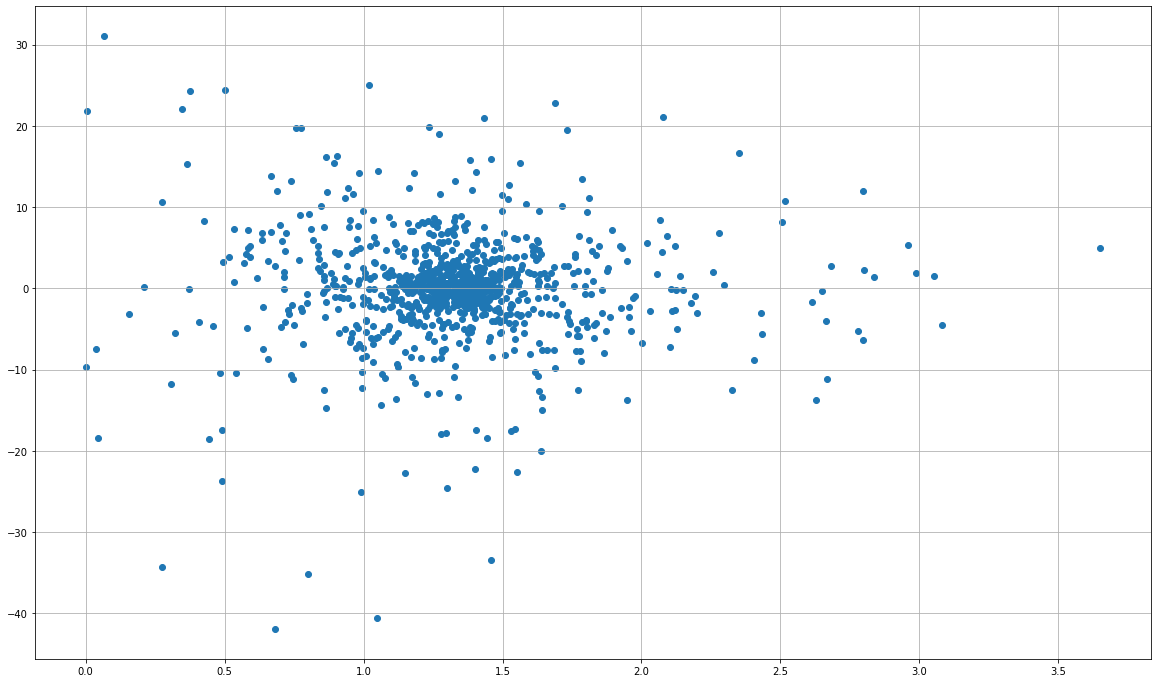

In [ ]:
plt.figure(figsize=(20,12))
plt.grid()
plt.scatter(rs['Predcit'], rs['Real'])
plt.show()

0부터 100까지


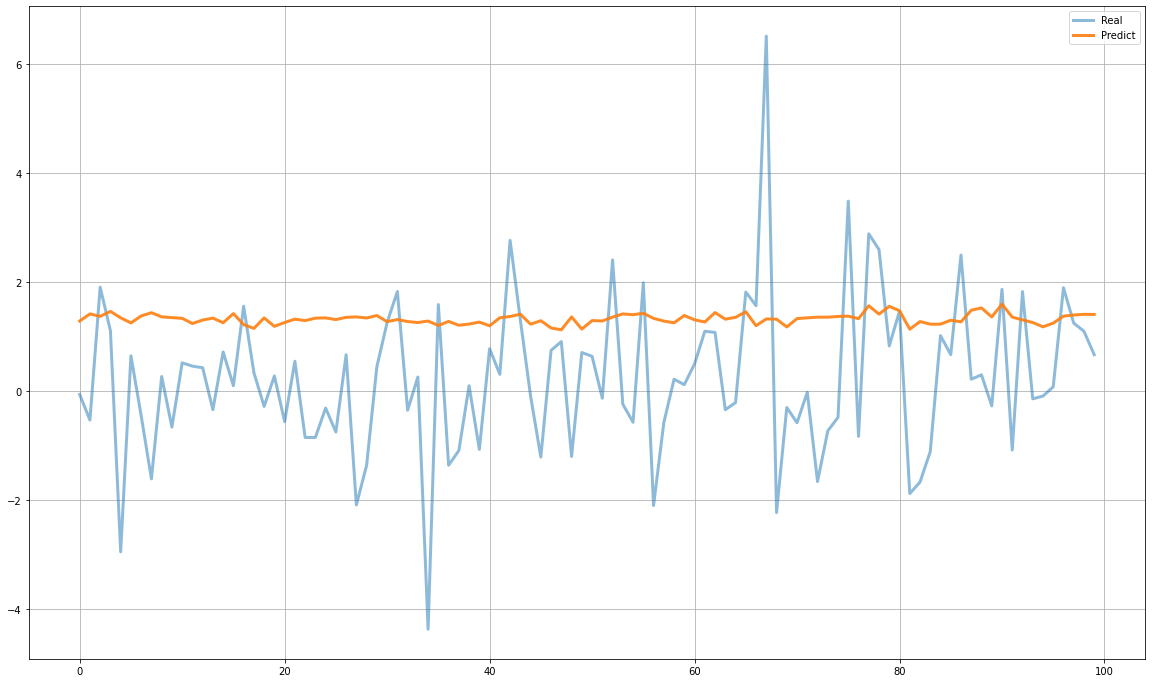

100부터 200까지


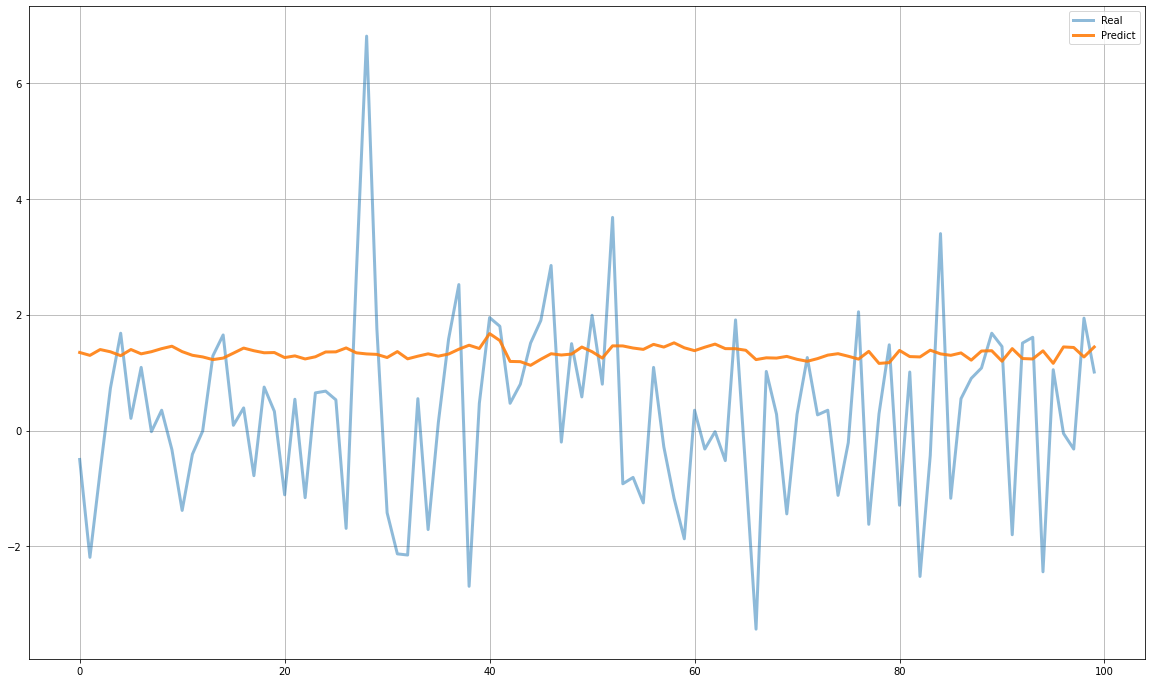

200부터 300까지


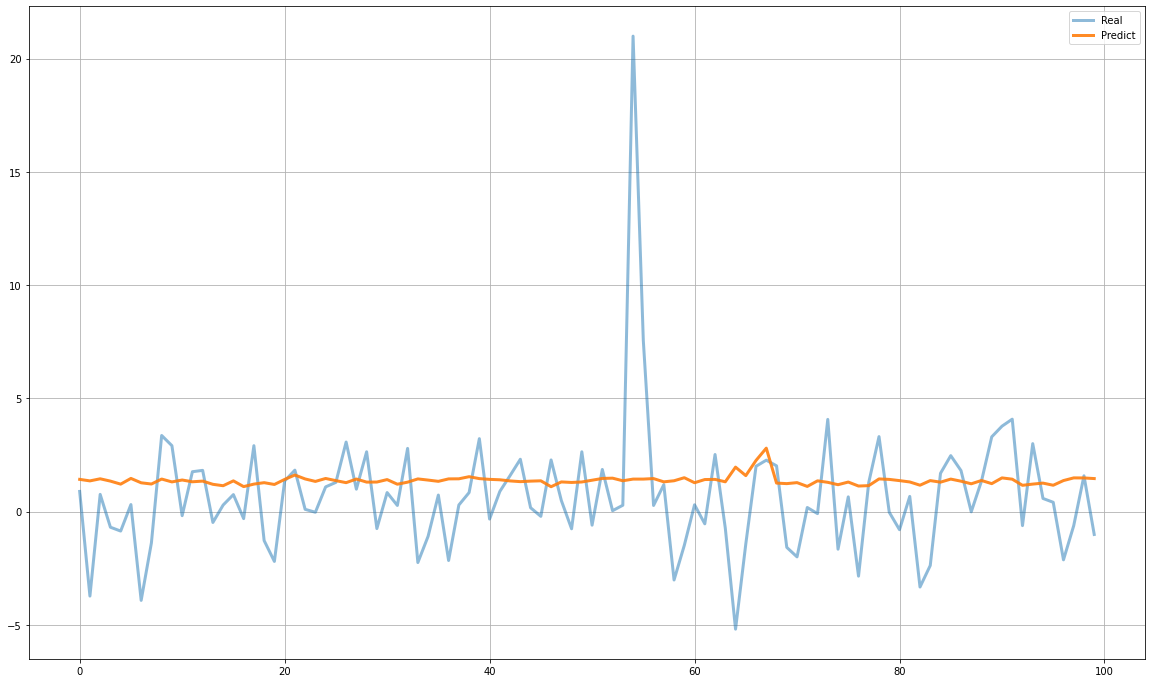

300부터 400까지


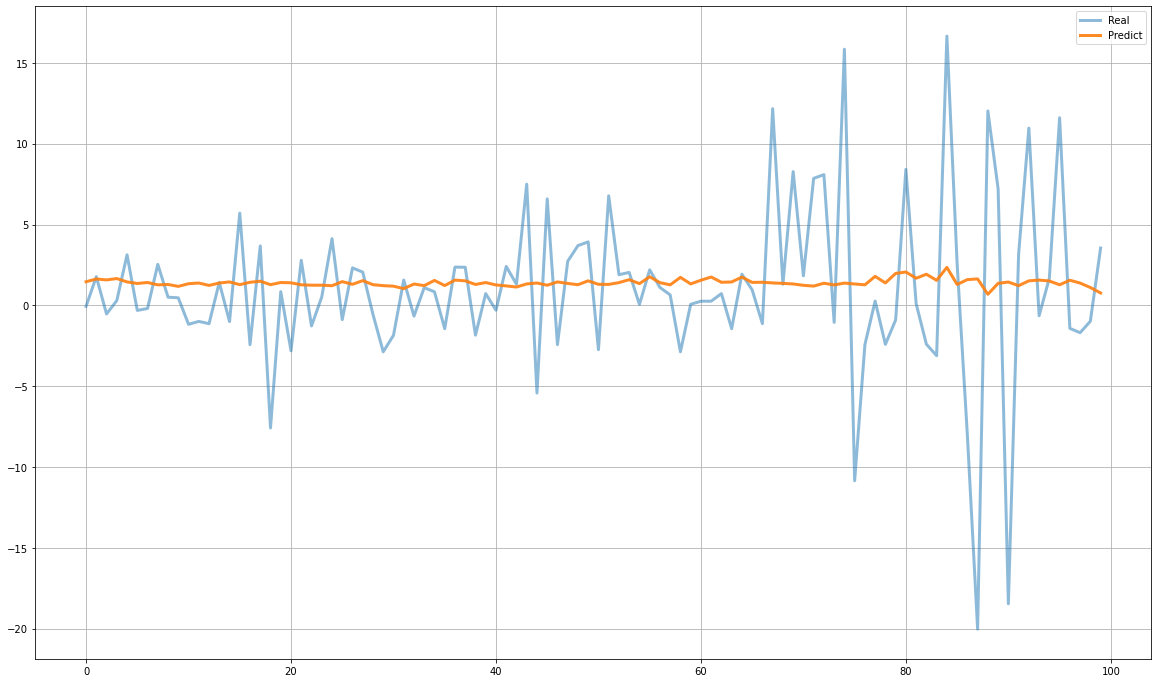

400부터 500까지


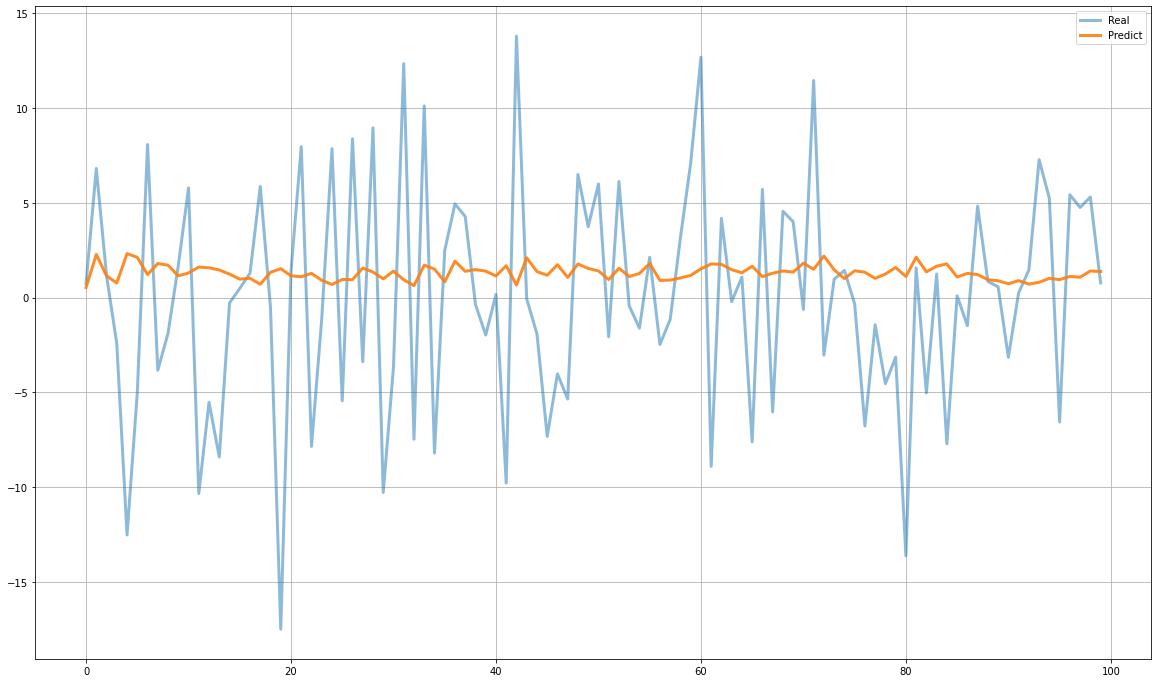

500부터 600까지


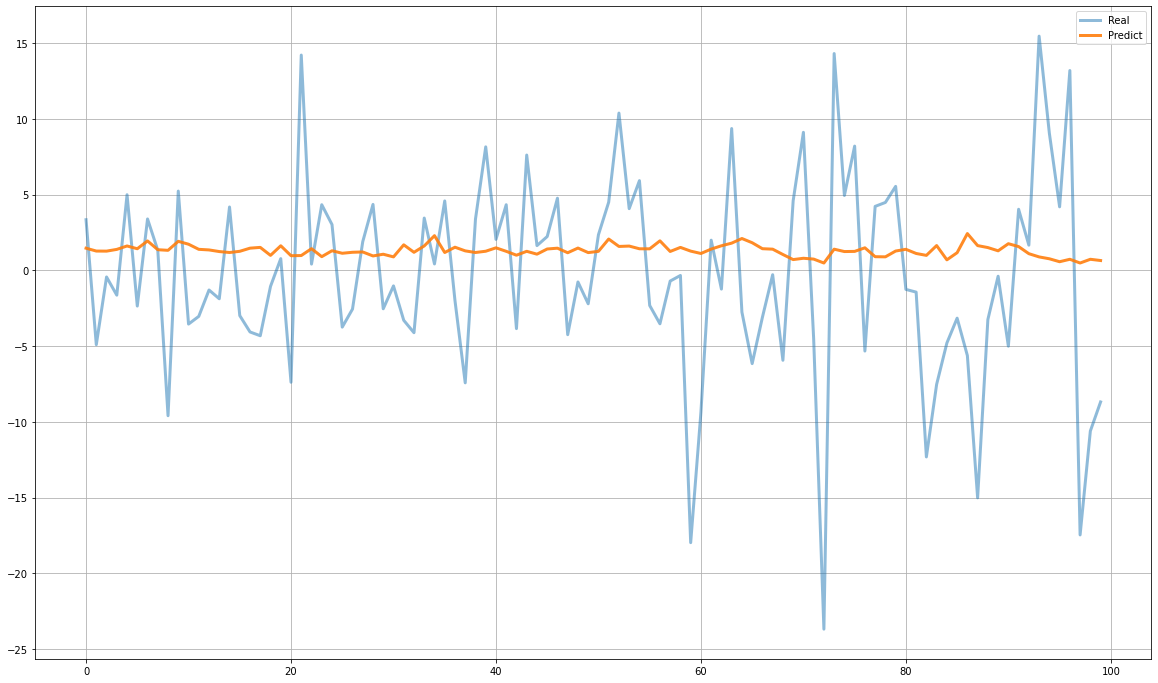

600부터 700까지


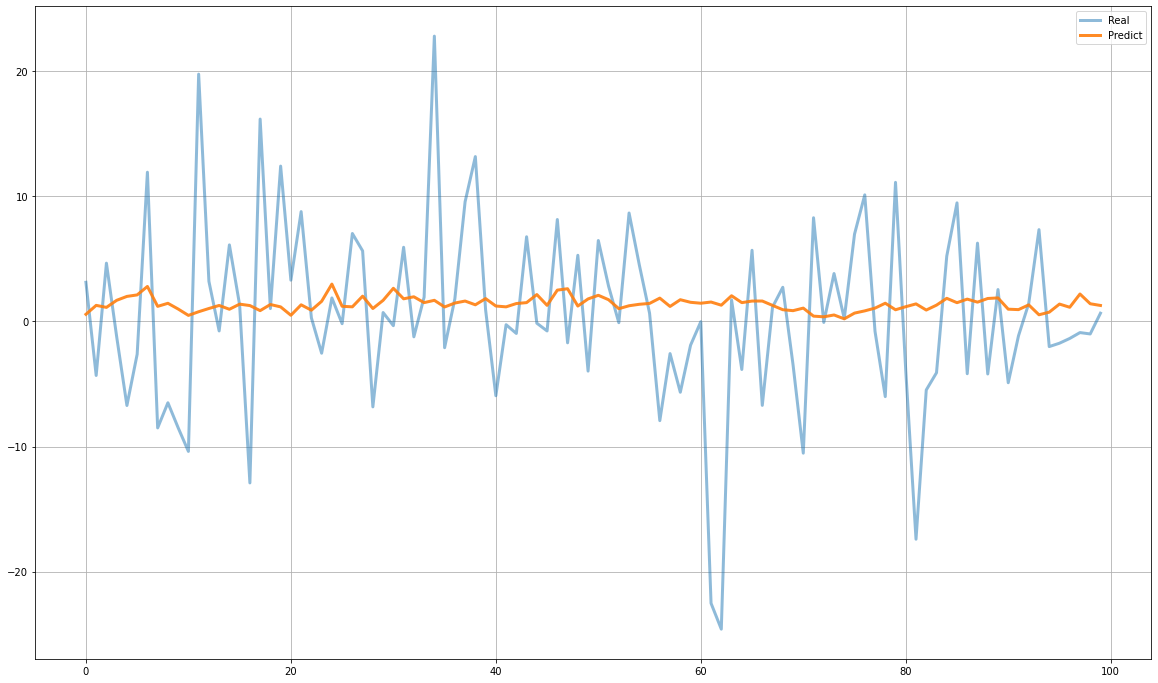

700부터 800까지


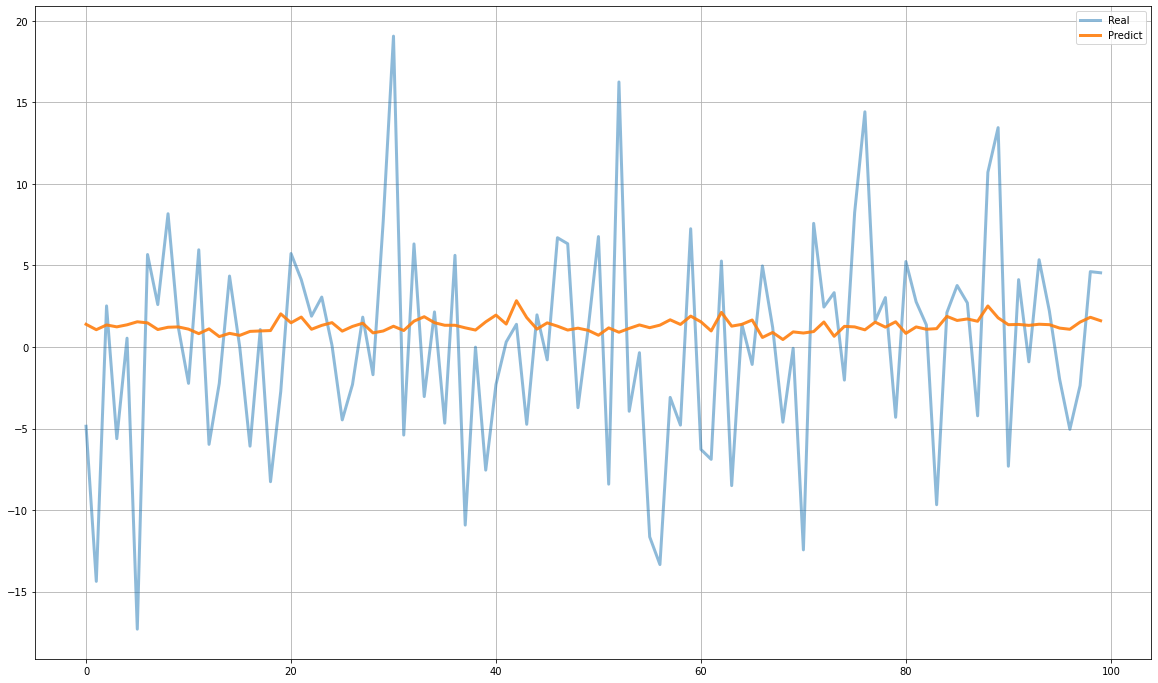

800부터 900까지


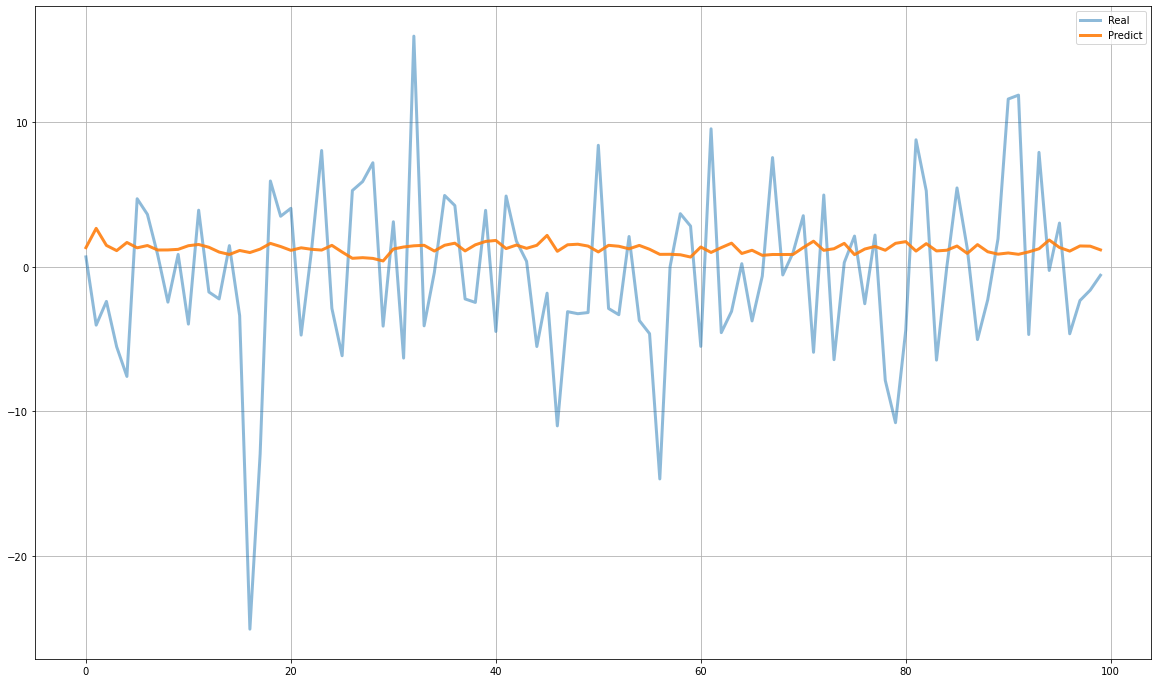

900부터 1000까지


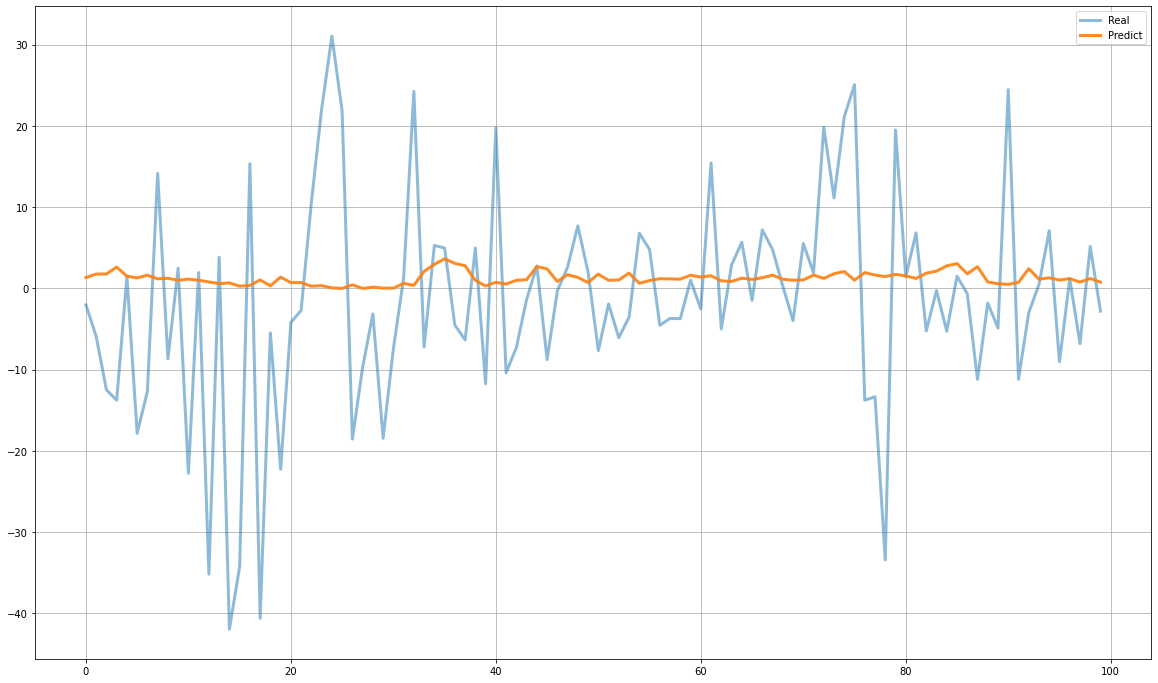

In [ ]:
for i in range(10):
  print(str(0+(i*100))+'부터', str(100+(i*100))+'까지')
  plt.figure(figsize=(20,12))
  plt.grid()
  plt.plot(range(100), rs['Real'][0+(i*100):100+(i*100)], label = 'Real', alpha = 0.5 ,linewidth=3.0)
  plt.plot(range(100), rs['Predcit'][0+(i*100):100+(i*100)], label = 'Predict', alpha = 0.9, linewidth=3.0)
  plt.legend(loc='best')
  plt.show()

In [ ]:
rs

,Predcit,Real,Error
0,1.29,-0.06,1.35
1,1.42,-0.53,1.95
2,1.37,1.91,-0.54
3,1.47,1.11,0.36
4,1.35,-2.95,4.30
...,...,...,...
995,1.04,-9.03,10.07
996,1.20,1.20,0.00
997,0.78,-6.80,7.58
998,1.22,5.16,-3.94


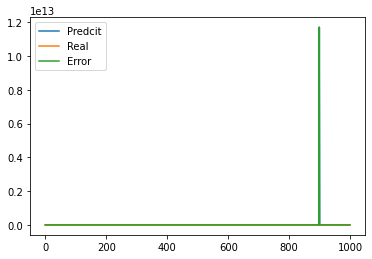

In [ ]:
datetime

NameError: ignored

In [ ]:
import datetime

In [ ]:
datetime.timedelta(days=1)

datetime.timedelta(1)